# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [4]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [5]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [6]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=False, reflect_z=True,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via longitunidnal flips
Total augmentation multiplicity is 2


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


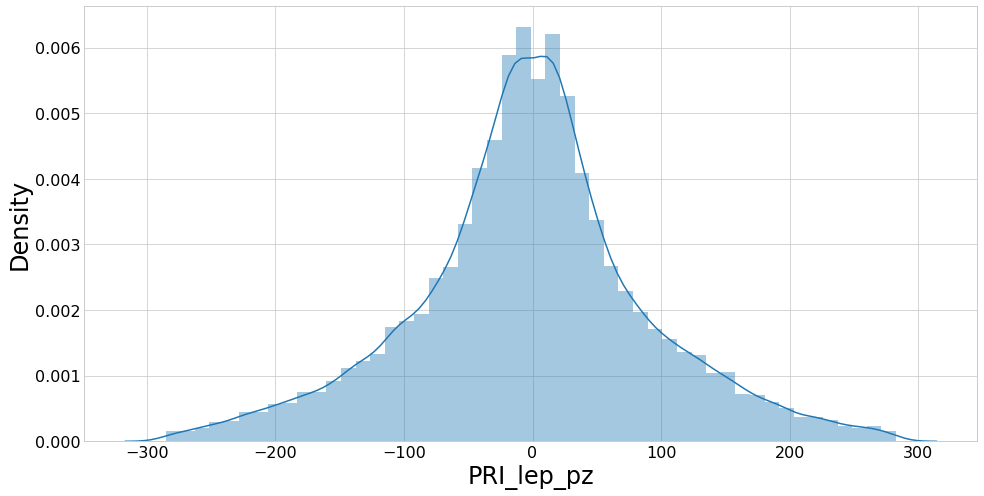

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


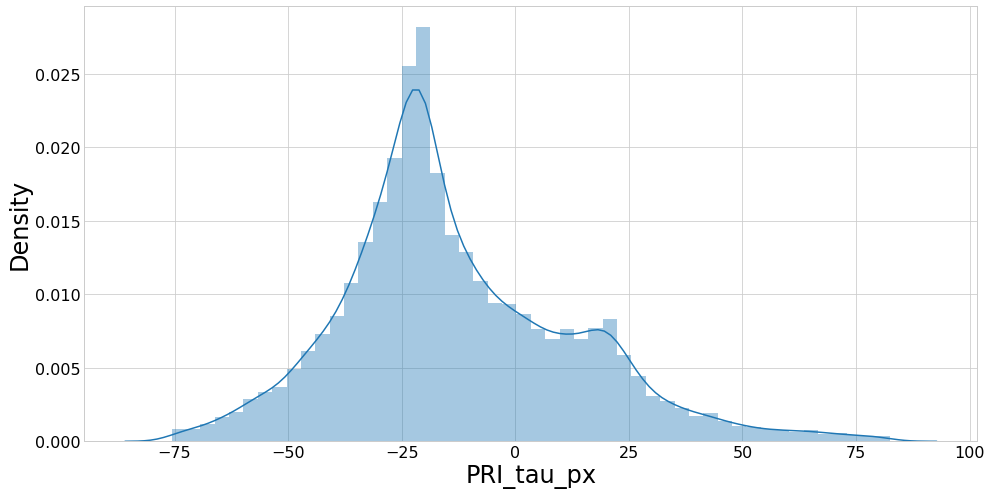

In [8]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')
plot_feat(data, 'PRI_tau_px')

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 15.844s 


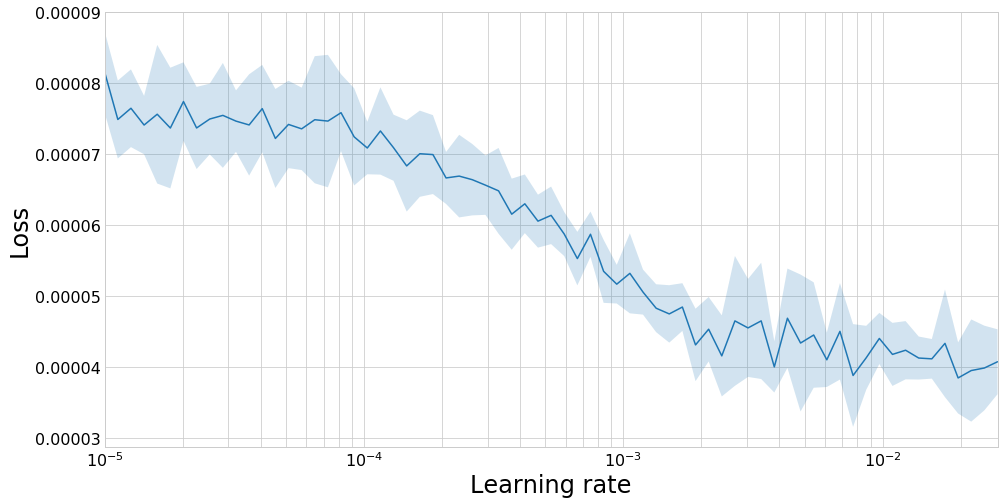

______________________________________



In [9]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [10]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103221). Check your callbacks.
  % delta_t_median)


1 New best found: 3.783954625978367e-05
2 New best found: 3.614902133849682e-05
3 New best found: 3.489875820378074e-05
4 New best found: 3.440921081783017e-05
5 New best found: 3.419026681804098e-05
6 New best found: 3.366132348019164e-05
7 New best found: 3.347579102410236e-05
9 New best found: 3.330588004901074e-05
12 New best found: 3.30484450700169e-05
13 New best found: 3.303025600180263e-05
14 New best found: 3.271306077658665e-05
24 New best found: 3.2464868848910556e-05
27 New best found: 3.240450493467506e-05
28 New best found: 3.232698567371699e-05
30 New best found: 3.232694620601251e-05
31 New best found: 3.232039404247189e-05
50 New best found: 3.2302487727429255e-05
52 New best found: 3.222055957230623e-05
54 New best found: 3.21117673178378e-05
55 New best found: 3.21077111424529e-05
59 New best found: 3.205784714300535e-05
60 New best found: 3.205029840755742e-05
108 New best found: 3.20392939800513e-05
112 New best found: 3.202589931024704e-05
113 New best found: 3.20

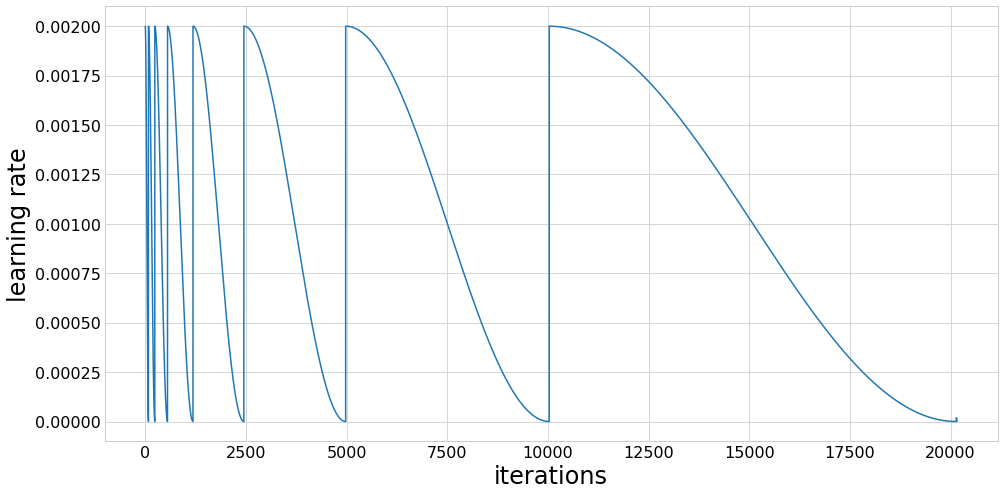

Fold took 212.109s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242939). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121794). Check your callbacks.
  % delta_t_median)


1 New best found: 3.733935372001724e-05
2 New best found: 3.601551832689438e-05
3 New best found: 3.4810272449976764e-05
4 New best found: 3.414314227120485e-05
5 New best found: 3.380315937829437e-05
7 New best found: 3.339850314805517e-05
11 New best found: 3.333403546712361e-05
12 New best found: 3.288005521026207e-05
13 New best found: 3.271588637580862e-05
14 New best found: 3.261277338460786e-05
15 New best found: 3.2591547293122856e-05
22 New best found: 3.2568212429760025e-05
26 New best found: 3.2448255427880214e-05
27 New best found: 3.23016035486944e-05
28 New best found: 3.227083789097378e-05
29 New best found: 3.225648493826156e-05
30 New best found: 3.2217771976138464e-05
50 New best found: 3.2121342467144134e-05
51 New best found: 3.211563655204373e-05
53 New best found: 3.207675107114483e-05
54 New best found: 3.2060251585789956e-05
56 New best found: 3.194879816146567e-05
58 New best found: 3.1943459941248874e-05
60 New best found: 3.193845458736178e-05
61 New best fou

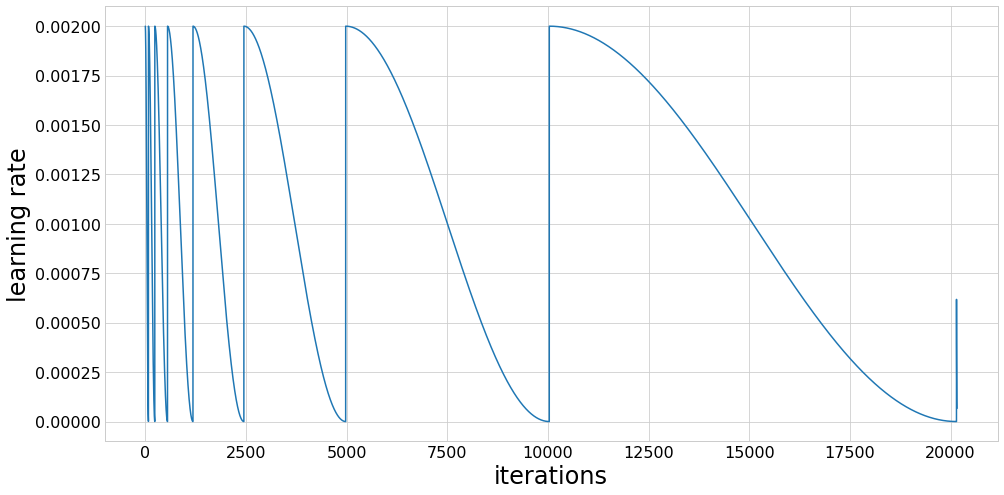

Fold took 214.760s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262389). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131556). Check your callbacks.
  % delta_t_median)


1 New best found: 3.677177539357217e-05
2 New best found: 3.4430288150906565e-05
3 New best found: 3.3820975535491016e-05
5 New best found: 3.345484775782097e-05
6 New best found: 3.280023693660041e-05
7 New best found: 3.260720917023718e-05
11 New best found: 3.249181080027483e-05
12 New best found: 3.242014824063517e-05
13 New best found: 3.223890592053067e-05
14 New best found: 3.208052171830786e-05
15 New best found: 3.207498127449071e-05
23 New best found: 3.202832786046201e-05
24 New best found: 3.185446491843322e-05
27 New best found: 3.1830187060404566e-05
28 New best found: 3.175464998057578e-05
29 New best found: 3.164056877576513e-05
30 New best found: 3.1629903624707366e-05
47 New best found: 3.157495685882168e-05
53 New best found: 3.148138859542087e-05
54 New best found: 3.1453175377100705e-05
56 New best found: 3.137517552240752e-05
62 New best found: 3.136847872665385e-05
63 New best found: 3.1366972764953974e-05
110 New best found: 3.130641139869112e-05
122 New best fo

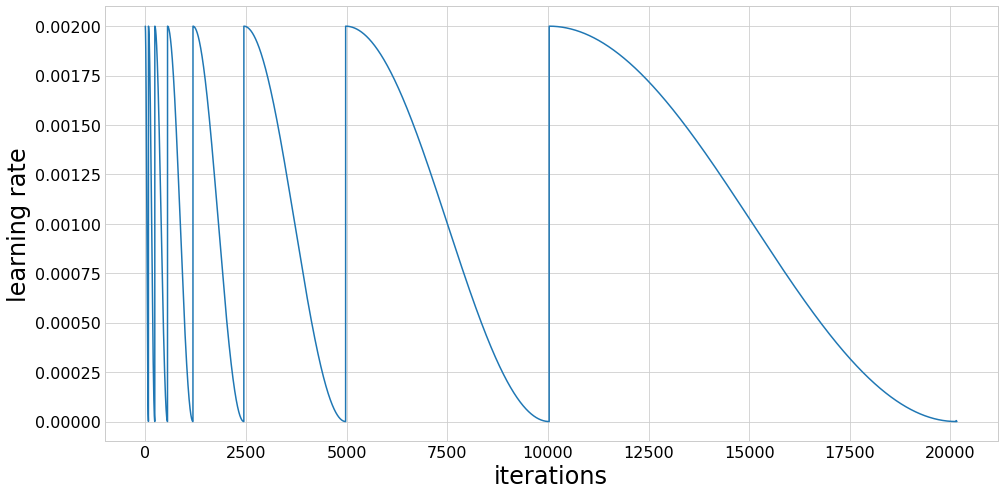

Fold took 227.331s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268664). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134709). Check your callbacks.
  % delta_t_median)


1 New best found: 3.797069011163592e-05
2 New best found: 3.559198684082661e-05
3 New best found: 3.49903224226102e-05
4 New best found: 3.4958069925250424e-05
5 New best found: 3.411931065415303e-05
6 New best found: 3.3765545726753466e-05
7 New best found: 3.3615427117310855e-05
11 New best found: 3.336238733287233e-05
13 New best found: 3.317468296996904e-05
14 New best found: 3.2963778426025444e-05
23 New best found: 3.284744985346313e-05
25 New best found: 3.283059411504915e-05
26 New best found: 3.2805736464085566e-05
27 New best found: 3.265678867352969e-05
29 New best found: 3.256663165569934e-05
30 New best found: 3.255291500736294e-05
31 New best found: 3.254326697295541e-05
50 New best found: 3.2518346705323464e-05
51 New best found: 3.236731761575767e-05
58 New best found: 3.233640450063838e-05
59 New best found: 3.2316819797556764e-05
60 New best found: 3.231103825363092e-05
61 New best found: 3.229769843822835e-05
114 New best found: 3.228406626784113e-05
CosineAnneal sta

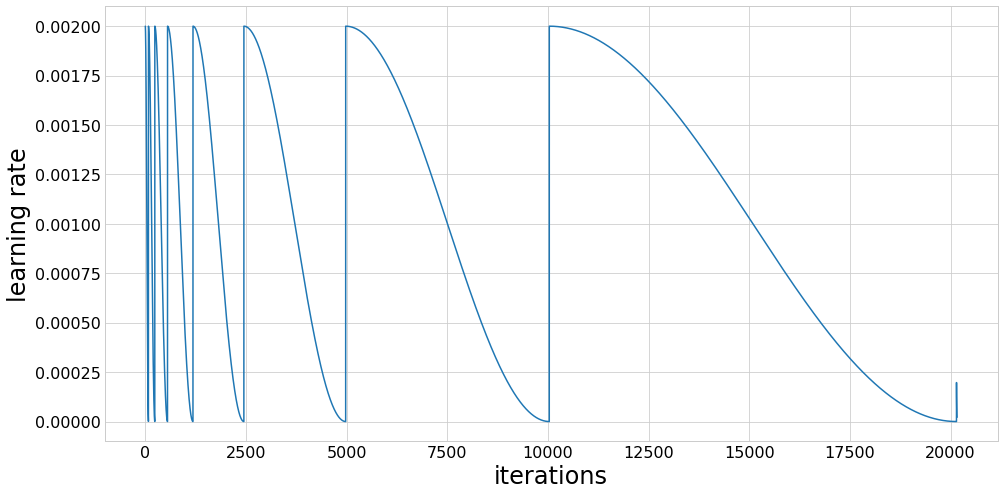

Fold took 227.954s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.318392). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159580). Check your callbacks.
  % delta_t_median)


1 New best found: 3.770487266511195e-05
2 New best found: 3.491680765573518e-05
3 New best found: 3.4357895102486004e-05
5 New best found: 3.3886291315306e-05
6 New best found: 3.327830740509196e-05
7 New best found: 3.3155788322265454e-05
11 New best found: 3.302864291868269e-05
12 New best found: 3.279797652187184e-05
13 New best found: 3.259843918404248e-05
14 New best found: 3.24820411534828e-05
15 New best found: 3.244834045100888e-05
25 New best found: 3.236848124035999e-05
26 New best found: 3.236052027776503e-05
27 New best found: 3.228329306561552e-05
29 New best found: 3.2172017774035725e-05
30 New best found: 3.2169583174538225e-05
31 New best found: 3.2163271522994054e-05
52 New best found: 3.213329465538153e-05
54 New best found: 3.2020773543497786e-05
56 New best found: 3.193118927816158e-05
61 New best found: 3.192332081846702e-05
62 New best found: 3.192213636884294e-05
63 New best found: 3.192143401643642e-05
110 New best found: 3.191381164333559e-05
114 New best found

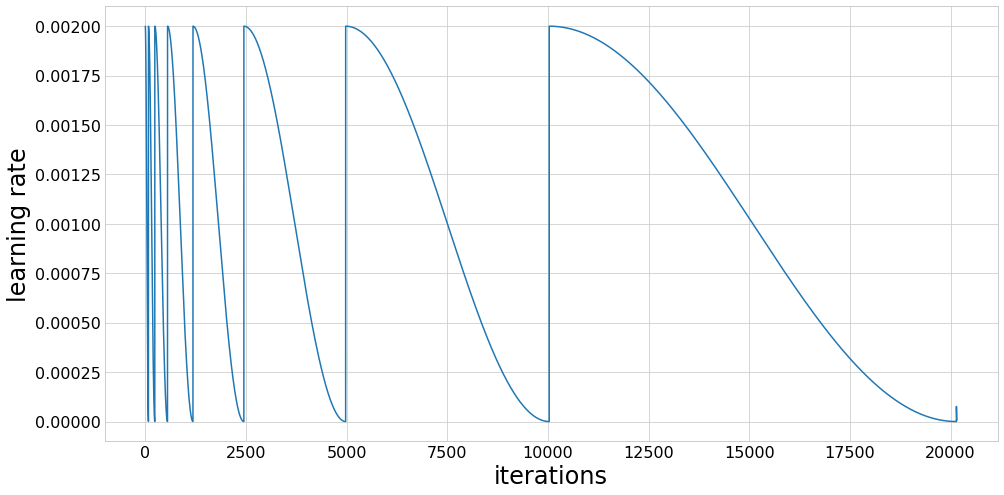

Fold took 233.808s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.345244). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172969). Check your callbacks.
  % delta_t_median)


1 New best found: 3.668215570272546e-05
2 New best found: 3.4382419932012744e-05
3 New best found: 3.3763114525254896e-05
5 New best found: 3.274653625946424e-05
6 New best found: 3.240032409390028e-05
7 New best found: 3.223935990913979e-05
11 New best found: 3.212052886442401e-05
12 New best found: 3.204572259431247e-05
13 New best found: 3.1515429272755674e-05
14 New best found: 3.1475253358123814e-05
15 New best found: 3.144709191470701e-05
23 New best found: 3.1145987188077554e-05
27 New best found: 3.110510707251294e-05
28 New best found: 3.109211139562883e-05
29 New best found: 3.107178686436569e-05
30 New best found: 3.1061040334999195e-05
45 New best found: 3.1032401527514475e-05
50 New best found: 3.099792596422206e-05
52 New best found: 3.099587389214127e-05
54 New best found: 3.084961621396995e-05
61 New best found: 3.0842454248298746e-05
62 New best found: 3.083636561607606e-05
63 New best found: 3.083560232904848e-05
CosineAnneal stalling after 255 epochs, entering redux 

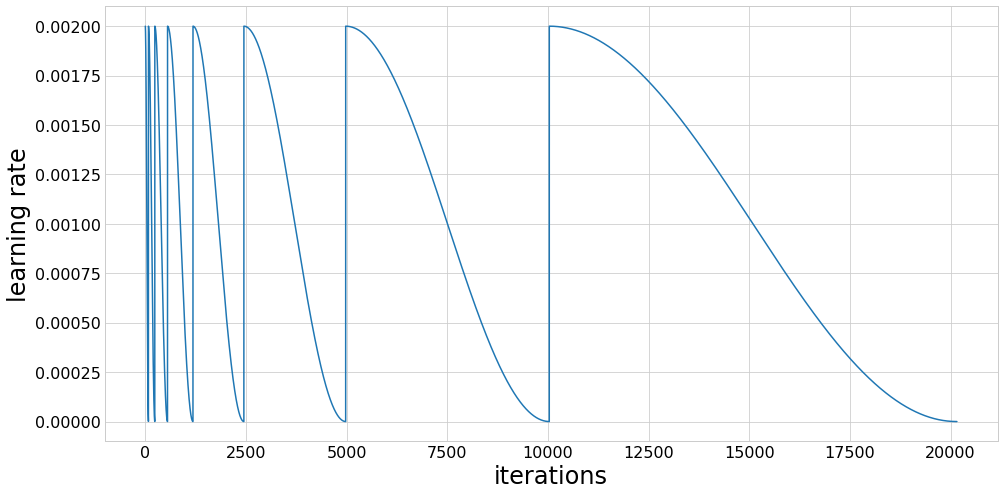

Fold took 236.120s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.351828). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176260). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7447543178859634e-05
2 New best found: 3.617277039156761e-05
3 New best found: 3.470279653556645e-05
5 New best found: 3.405271336087026e-05
6 New best found: 3.3620181592414154e-05
7 New best found: 3.348099665454356e-05
12 New best found: 3.338151030766312e-05
13 New best found: 3.299232605859288e-05
14 New best found: 3.2966390069486805e-05
15 New best found: 3.293691133294488e-05
20 New best found: 3.287402910646051e-05
25 New best found: 3.2557853098842314e-05
27 New best found: 3.255192894139327e-05
28 New best found: 3.251154972313088e-05
29 New best found: 3.2470184403064195e-05
30 New best found: 3.241731905436609e-05
31 New best found: 3.240781568238163e-05
48 New best found: 3.2404968183254824e-05
52 New best found: 3.2236778914375464e-05
53 New best found: 3.2214705906517336e-05
54 New best found: 3.2167675397795395e-05
56 New best found: 3.214896285207942e-05
57 New best found: 3.2130633530323395e-05
58 New best found: 3.206397044559708e-05
103 New best

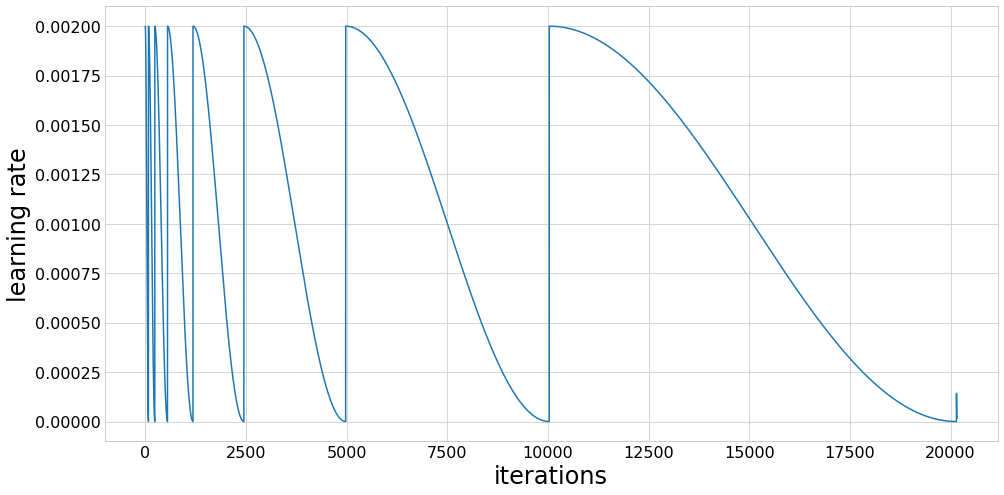

Fold took 237.745s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.366502). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183652). Check your callbacks.
  % delta_t_median)


1 New best found: 3.651777684227721e-05
2 New best found: 3.5077608196028726e-05
3 New best found: 3.418429198875533e-05
5 New best found: 3.333166895834406e-05
6 New best found: 3.2715026697508476e-05
7 New best found: 3.2690221308550614e-05
12 New best found: 3.235225409305531e-05
13 New best found: 3.214788237294112e-05
14 New best found: 3.208206692104899e-05
15 New best found: 3.20614839792342e-05
23 New best found: 3.195108080075718e-05
26 New best found: 3.1891299829976016e-05
27 New best found: 3.188025423497619e-05
28 New best found: 3.180060017283087e-05
29 New best found: 3.174399936644547e-05
30 New best found: 3.17245358258345e-05
31 New best found: 3.17157195620185e-05
51 New best found: 3.1627902842362226e-05
52 New best found: 3.1627438442516194e-05
53 New best found: 3.161985158806099e-05
55 New best found: 3.16178380387359e-05
56 New best found: 3.1571336534017226e-05
58 New best found: 3.1524878366068504e-05
60 New best found: 3.151138326931286e-05
61 New best found:

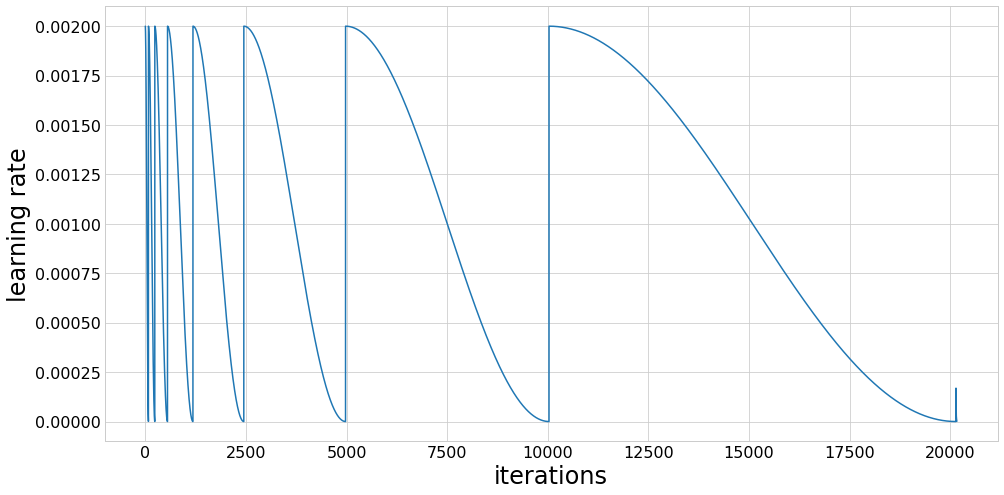

Fold took 253.570s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.419286). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210011). Check your callbacks.
  % delta_t_median)


1 New best found: 3.754042624396257e-05
2 New best found: 3.5190836602246904e-05
3 New best found: 3.478914882075975e-05
5 New best found: 3.393763592935975e-05
6 New best found: 3.365020464772472e-05
7 New best found: 3.343612105396635e-05
11 New best found: 3.308319310427085e-05
12 New best found: 3.288105546240834e-05
13 New best found: 3.26900070896421e-05
14 New best found: 3.26546056334038e-05
15 New best found: 3.261505848500841e-05
20 New best found: 3.2484191153938635e-05
24 New best found: 3.242593696929652e-05
26 New best found: 3.212108779107192e-05
28 New best found: 3.211724846408482e-05
29 New best found: 3.208782853983455e-05
30 New best found: 3.2057248747862716e-05
47 New best found: 3.195618441447937e-05
53 New best found: 3.1848089800205985e-05
56 New best found: 3.177992233996134e-05
92 New best found: 3.165438994540312e-05
115 New best found: 3.163803721796528e-05
116 New best found: 3.161556507857203e-05
117 New best found: 3.1597030332084435e-05
118 New best fou

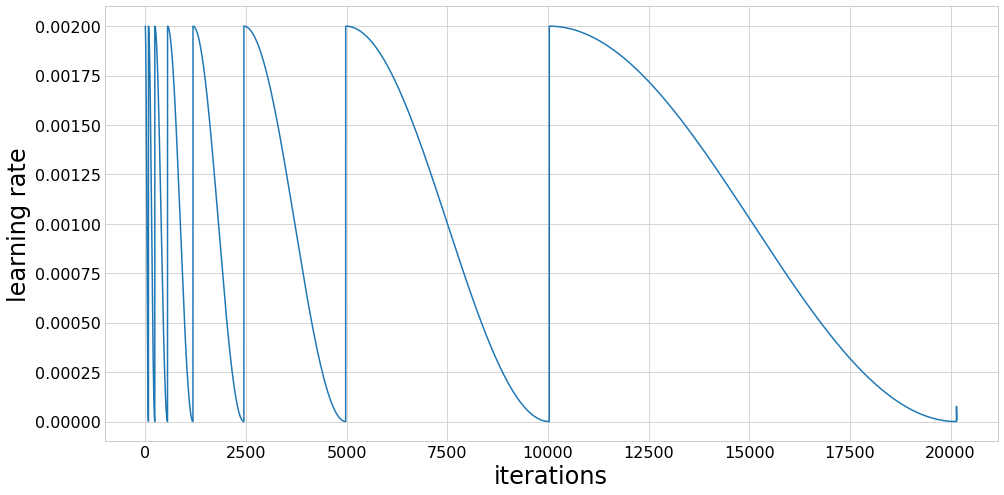

Fold took 249.596s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.450322). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225556). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7016582031190584e-05
2 New best found: 3.541644248195204e-05
3 New best found: 3.429852938911058e-05
5 New best found: 3.3544864475813636e-05
6 New best found: 3.3290696832376125e-05
7 New best found: 3.30931270239472e-05
11 New best found: 3.2917296057656604e-05
12 New best found: 3.263871853235023e-05
13 New best found: 3.241162975936257e-05
14 New best found: 3.2319333657331216e-05
15 New best found: 3.226030909777222e-05
22 New best found: 3.218530674562364e-05
24 New best found: 3.2159119547754096e-05
25 New best found: 3.197905531925102e-05
26 New best found: 3.1963584935479134e-05
27 New best found: 3.190066146899967e-05
28 New best found: 3.1872628163877105e-05
29 New best found: 3.185746169527035e-05
30 New best found: 3.182441892807486e-05
31 New best found: 3.182177470181619e-05
42 New best found: 3.180567264671046e-05
49 New best found: 3.1794005939819926e-05
53 New best found: 3.168399957280348e-05
54 New best found: 3.163313790773612e-05
58 New best fo

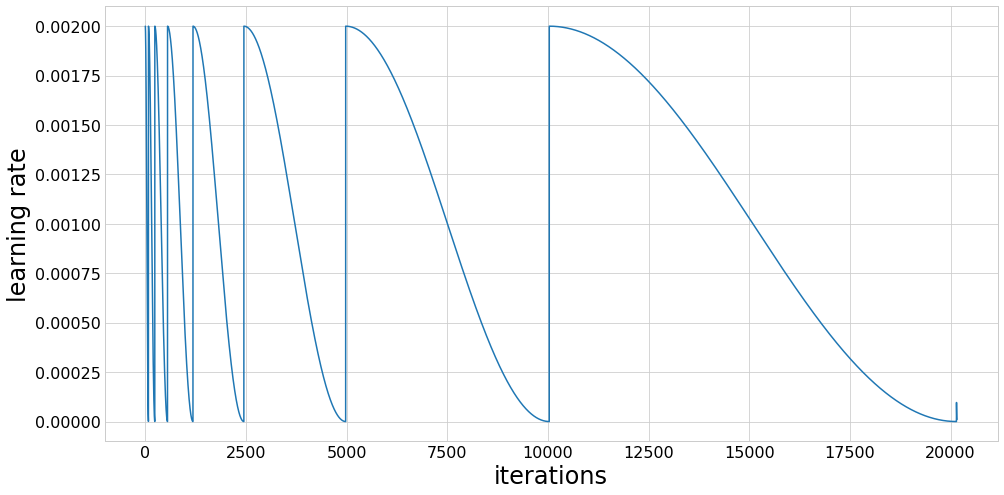

Fold took 252.075s


______________________________________
Training finished
Cross-validation took 2348.044s 


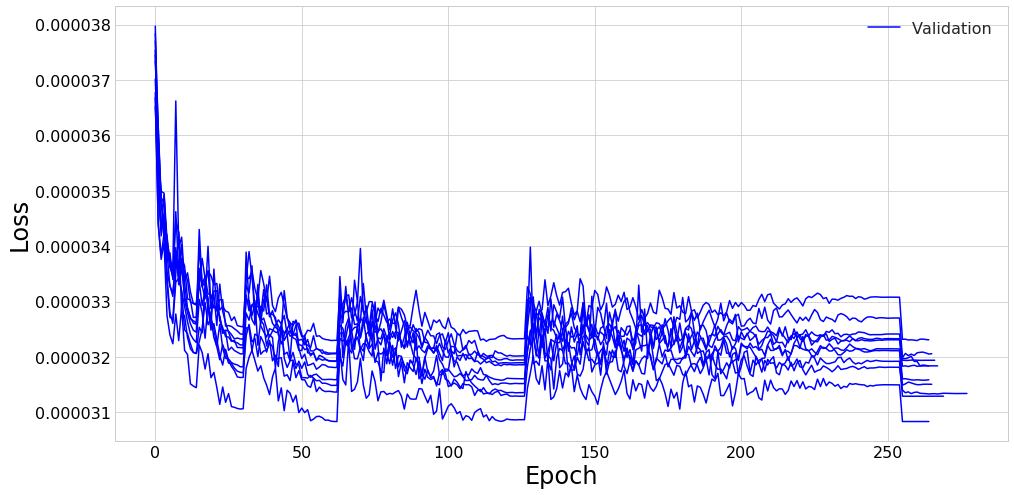

Mean loss = 3.16e-05 +- 1e-07
Mean wAUC = 0.0627 +- 0.0005
Mean AUC = 0.0976 +- 0.0008
Mean AMS = 3.96 +- 0.08
Mean cut = 0.964 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [11]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [12]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [13]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 5 with loss = 3.083560232904848e-05
Model 1 is 2 with loss = 3.129142339312238e-05
Model 2 is 7 with loss = 3.133247946150254e-05
Model 3 is 9 with loss = 3.1492734064445096e-05
Model 4 is 8 with loss = 3.1580464160833764e-05
Model 5 is 1 with loss = 3.1821297995338684e-05
Model 6 is 4 with loss = 3.182849001737538e-05
Model 7 is 0 with loss = 3.19378610161948e-05
Model 8 is 6 with loss = 3.198829409739119e-05
Model 9 is 3 with loss = 3.228406626784113e-05


## Response on validation data without TTA

In [14]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [15]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001827729370072484s per sample

Predicting fold 2 out of 10
Prediction took 0.00034819380715489387s per sample

Predicting fold 3 out of 10
Prediction took 0.0003521427059546113s per sample

Predicting fold 4 out of 10
Prediction took 0.0003483011791482568s per sample

Predicting fold 5 out of 10
Prediction took 0.00035599606949836016s per sample

Predicting fold 6 out of 10
Prediction took 0.0003484478533267975s per sample

Predicting fold 7 out of 10
Prediction took 0.00034816257562488316s per sample

Predicting fold 8 out of 10
Prediction took 0.00034778679553419353s per sample

Predicting fold 9 out of 10
Prediction took 0.0003479754719883204s per sample

Predicting fold 10 out of 10
Prediction took 0.00034867707546800374s per sample



In [16]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9044154416251009, weighted 0.936425575810951


In [17]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.950397976288832, 0.9652221)

In [18]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.97+-0.01
Exact mean cut 0.9651029490632936, corresponds to calc_ams of 3.945228304544393
CPU times: user 2.35 s, sys: 17.8 s, total: 20.1 s
Wall time: 2min 1s


(4.0, 0.97)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [19]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=False, reflect_z=True,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via longitunidnal flips
Total augmentation multiplicity is 2


In [20]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0007085555942729115s per sample

Predicting fold 2 out of 10
Prediction took 0.0006980353035032749s per sample

Predicting fold 3 out of 10
Prediction took 0.0006955643376335502s per sample

Predicting fold 4 out of 10
Prediction took 0.0007070248257368803s per sample

Predicting fold 5 out of 10
Prediction took 0.0006969188472256064s per sample

Predicting fold 6 out of 10
Prediction took 0.0006994319934397936s per sample

Predicting fold 7 out of 10
Prediction took 0.0006972204180434346s per sample

Predicting fold 8 out of 10
Prediction took 0.0007060975750908256s per sample

Predicting fold 9 out of 10
Prediction took 0.000703084447234869s per sample

Predicting fold 10 out of 10
Prediction took 0.0007022080039605498s per sample



In [21]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9044751952217668, weighted 0.9364361412262525


In [22]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9624935627873863, 0.9648647)

In [23]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.964638531091623, corresponds to calc_ams of 3.9411848898859994
CPU times: user 2.41 s, sys: 17 s, total: 19.4 s
Wall time: 2min 2s


(4.0, 0.96)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [30]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [31]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00034586349928920917s per sample

Predicting fold 2 out of 10
Prediction took 0.0003465251633220098s per sample

Predicting fold 3 out of 10
Prediction took 0.0003475918045267463s per sample

Predicting fold 4 out of 10
Prediction took 0.00034769646489823404s per sample

Predicting fold 5 out of 10
Prediction took 0.0003439557526091283s per sample

Predicting fold 6 out of 10
Prediction took 0.00034546011156317863s per sample

Predicting fold 7 out of 10
Prediction took 0.00034519415474073455s per sample

Predicting fold 8 out of 10
Prediction took 0.00034640212543308736s per sample

Predicting fold 9 out of 10
Prediction took 0.0003471207241104408s per sample

Predicting fold 10 out of 10
Prediction took 0.0003453572372821244s per sample

CPU times: user 3min 24s, sys: 11.8 s, total: 3min 36s
Wall time: 3min 10s


In [32]:
score_test_data(test_fy.source, 0.9651029490632936)

Public:Private AMS: 3.6176316384385103 : 3.7228348270588634


(3.6176316384385103, 3.7228348270588634)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [26]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=False, reflect_z=True,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via longitunidnal flips
Total augmentation multiplicity is 2


In [27]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0006955951105972583s per sample

Predicting fold 2 out of 10
Prediction took 0.0006942926962097937s per sample

Predicting fold 3 out of 10
Prediction took 0.0006926417548209429s per sample

Predicting fold 4 out of 10
Prediction took 0.0006984161192381923s per sample

Predicting fold 5 out of 10
Prediction took 0.0006986136344854127s per sample

Predicting fold 6 out of 10
Prediction took 0.0006963667119091208s per sample

Predicting fold 7 out of 10
Prediction took 0.0006956289248710328s per sample

Predicting fold 8 out of 10
Prediction took 0.0006975496976551684s per sample

Predicting fold 9 out of 10
Prediction took 0.0006931024518371983s per sample

Predicting fold 10 out of 10
Prediction took 0.0006948818277059631s per sample

CPU times: user 6min 51s, sys: 23.3 s, total: 7min 15s
Wall time: 6min 22s


In [29]:
score_test_data(test_fy.source, 0.964638531091623)

Public:Private AMS: 3.669125163500811 : 3.7230914409633606


(3.669125163500811, 3.7230914409633606)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)